In [1]:
# Main Analysis.

In [2]:
import import_ipynb

from Core import (columns_with_empty_data, correlation_heatmap,
plot_regplot, count_plot, plot_stack, plot_log, model_results, 
plot_residuals, replace_column_values, replace_na_with_none, replace_column_values, replace_na_with_zero,
replace_na_with_mode, replace_categorical_values, caluclate_cumsum, plot_pca, plot_pca_variance, dummy_df)
#################################################################
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import ElasticNet,Lasso, LinearRegression, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC, SVR
#################################################################
import xgboost as xgb
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor
import matplotlib.pyplot as plt

importing Jupyter notebook from Core.ipynb


In [3]:
# Import data
data = pd.read_csv('data/hour.csv')
np.random.seed(42)

# Explanatory Data Analysis (EDA)

In [4]:
print("Hour data: ", data.shape)

Hour data:  (17379, 17)


In [5]:
data.head()

instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

In [6]:
data.describe()

instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.192556   
min        0.000000      0.000000      0.000000      1.000000      0.020000   
25%        0.000000      1.000000      0.000000      1.000000      0.340000   
50%        0.000000      3.000000      1.000000      1.000000      0.500000   
75%        0.000000      5.000000      1.000000      2.000000      0.660000   
max        1.000000      6.000000      1.000000      4.000000      1.000000   

              atemp           hum     windspeed        casual    registered  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775      0.627229      0.190098     35.676218    153.786869   
std        0.171850      0.192930      0.122340     49.305030    151.357286   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.333300      0.480000      0.104500      4.000000     34.000000   
50%        0.484800      0.630000      0.194000     17.000000    115.000000   
75%        0.621200      0.780000      0.253700     48.000000    220.000000   
max        1.000000      1.000000      0.850700    367.000000    886.000000   

                cnt  
count  17379.000000  
mean     189.463088  
std      181.387599  
min        1.000000  
25%       40.000000  
50%      142.000000  
75%      281.000000  
max      977.000000

No empty data, which is good!

In [7]:
columns_with_empty_data(data)

Series([], dtype: int64)

There is high correlation between "cnt" - "registered" and "atemp" - "temp". We should eleminate one variable or use discriminant analysis

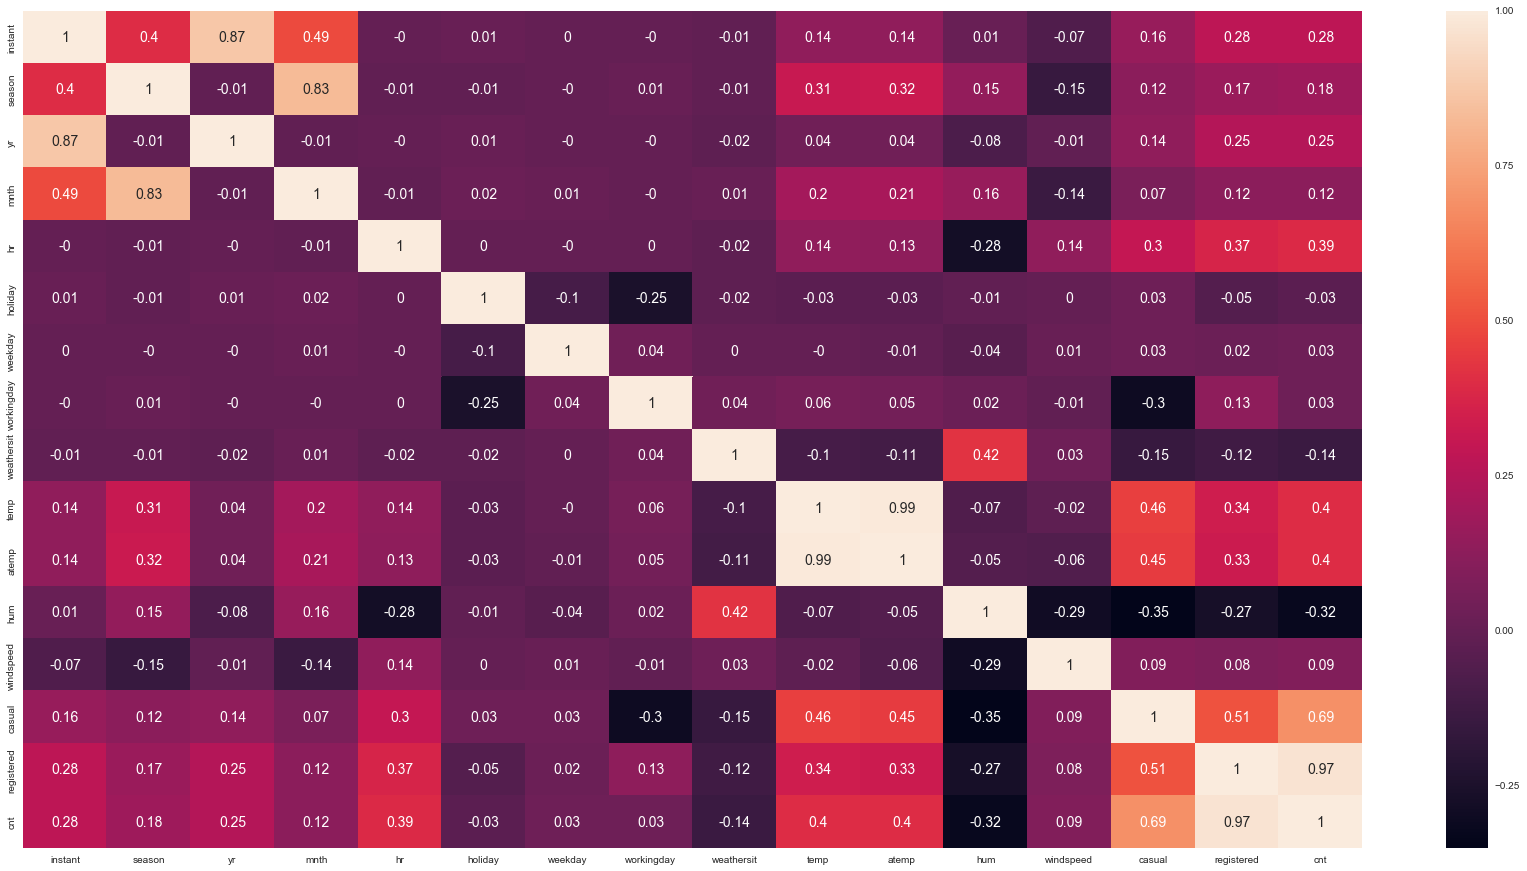

In [8]:
correlation_heatmap(data.loc[:, data.columns != 'dteday'])

Nothing intersting for the variables instant, yr, holiday, weekday, workingday, and hum.

In the next five plots we can see that:

1. As windspeed increases less bikes are used. Especially after 0.4
2. People use bikes when the temperature is not low.
3. The distribution of bikes is exponential.
4. Weather plays a huge role, which was expected.
5. If we log the cnt variable it will be closer to normal distribution.

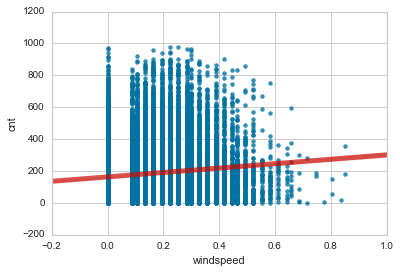

In [9]:
plot_regplot(data, "windspeed", "cnt")

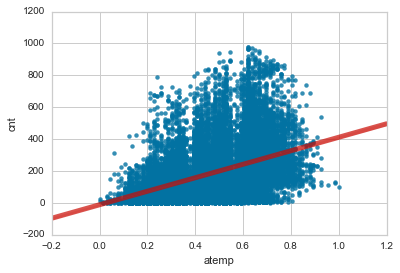

In [10]:
plot_regplot(data, "atemp","cnt")

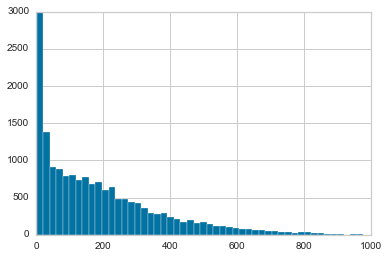

In [11]:
data['cnt'].hist(bins=50)

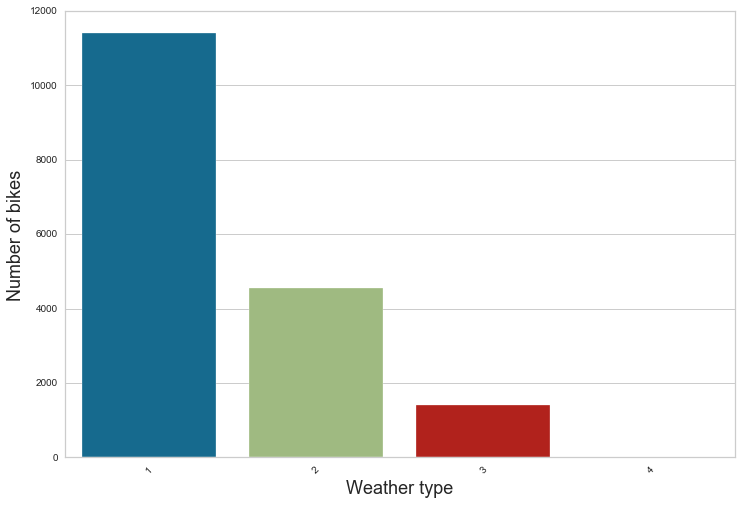

In [12]:
count_plot(data, 'weathersit', '', "Weather type", 'Number of bikes')

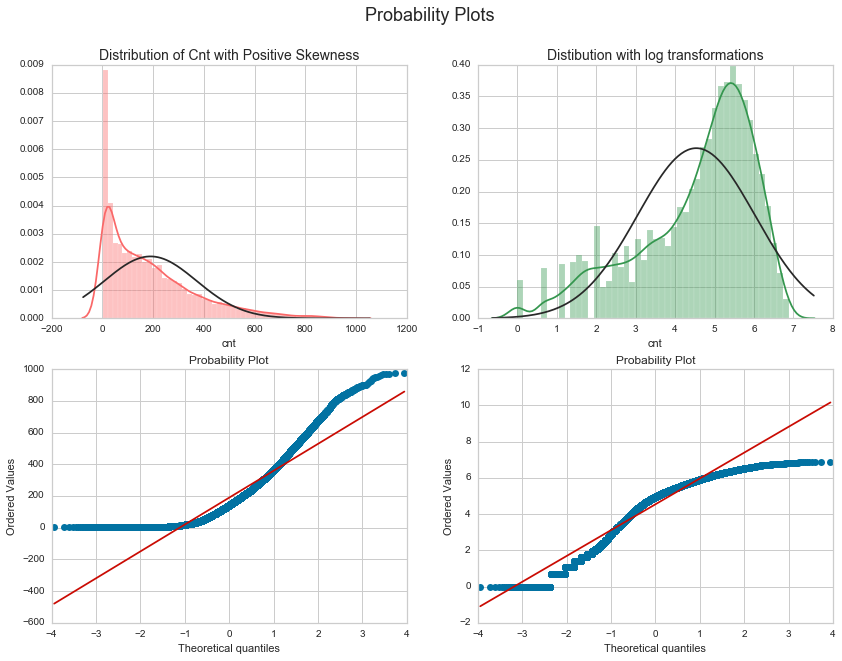

In [13]:
plot_log(data, 'cnt', 'Distribution of Cnt with Positive Skewness')

In [14]:
# Feature Transformation/Engineering

Variables that have high correlation or are not useful at all must be dropped.

In [15]:
data.drop(['instant', 'dteday', 'casual', 'registered', 'atemp'], axis=1, inplace=True)

Create dummy variables for month, weekday, weather, hours and seasons. We need to do that as the algorithms will consider that weekday 1 has lower value that weekday 2, which does not apply in our case.

In [16]:
data = dummy_df(data, ['mnth', 'weekday', 'weathersit', 'hr', 'season'])

In [17]:
# Check new dataset.
data.head()

yr  holiday  workingday  temp   hum  windspeed  cnt  mnth_1  mnth_2  \
0   0        0           0  0.24  0.81        0.0   16       1       0   
1   0        0           0  0.22  0.80        0.0   40       1       0   
2   0        0           0  0.22  0.80        0.0   32       1       0   
3   0        0           0  0.24  0.75        0.0   13       1       0   
4   0        0           0  0.24  0.75        0.0    1       1       0   

   mnth_3    ...     hr_18  hr_19  hr_20  hr_21  hr_22  hr_23  season_1  \
0       0    ...         0      0      0      0      0      0         1   
1       0    ...         0      0      0      0      0      0         1   
2       0    ...         0      0      0      0      0      0         1   
3       0    ...         0      0      0      0      0      0         1   
4       0    ...         0      0      0      0      0      0         1   

   season_2  season_3  season_4  
0         0         0         0  
1         0         0         0  
2         0         0         0  
3         0         0         0  
4         0         0         0  

[5 rows x 58 columns]

In [18]:
# Create X and y. The log of the response value is used.
X = pd.DataFrame(data, columns = data.columns)
y = np.log(data['cnt'])
X = X.drop('cnt', axis=1)

# Model - RandomForestRegressor

In [19]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [20]:
parameters = {"n_estimators" : [5, 10, 15, 20], "criterion" : ["mse" , "mae"], "min_samples_split" : [2, 3, 5, 10], 
                 "max_features" : ["auto", "log2"]}

model_results(RandomForestRegressor(), parameters, X_train, y_train, X_valid, y_valid)

Best Model: RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=3,
           min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)
 Best Score: 0.9316070130840934
 RMSE Score: 0.3814632741847228
 Cross Validation Score: 0.9354787718958348


(RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
            max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=3,
            min_weight_fraction_leaf=0.0, n_estimators=15, n_jobs=None,
            oob_score=False, random_state=None, verbose=0, warm_start=False),
 0.9316070130840934,
 0.3814632741847228,
 0.9354787718958348)

In [21]:
rf = RandomForestRegressor(n_estimators = 5, random_state=1).fit(X_train, y_train)

rf.feature_importances_

array([2.79274020e-02, 2.05910777e-03, 7.27647682e-02, 8.52283212e-02,
       2.27917409e-02, 1.19716643e-02, 1.19816617e-03, 1.01242964e-03,
       2.15451417e-03, 1.32993274e-03, 8.54483810e-04, 5.89252602e-04,
       4.33011102e-04, 4.80277202e-04, 5.53861129e-04, 9.06277012e-04,
       7.08500178e-04, 2.57950626e-03, 1.87235102e-03, 1.71343652e-03,
       1.48668014e-03, 1.22085552e-03, 1.35539589e-03, 3.64508738e-03,
       1.38653475e-03, 1.92676395e-03, 1.02013148e-03, 8.57864833e-03,
       2.18313048e-06, 3.77060060e-02, 7.79409626e-02, 1.06650233e-01,
       1.31062910e-01, 1.63209847e-01, 9.76057434e-02, 2.97475334e-02,
       1.18113316e-02, 9.72766616e-03, 2.24620983e-03, 1.92479487e-03,
       9.73571510e-04, 4.76486578e-04, 3.79771249e-04, 6.07276279e-04,
       2.43030926e-04, 1.65808457e-03, 7.72839234e-03, 5.85587919e-03,
       2.95343285e-03, 2.15690874e-03, 2.70922409e-03, 5.91495143e-03,
       1.69343998e-02, 1.41393258e-02, 1.43604952e-03, 6.47328266e-04,
      

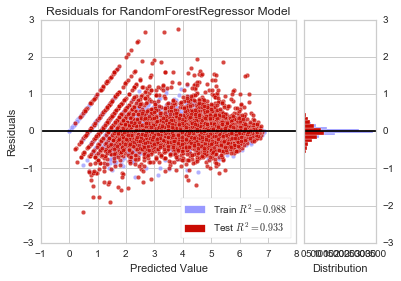

In [22]:
plot_residuals(RandomForestRegressor(), X_train, y_train, X_valid, y_valid)

The mean absolute deviations is a measure of sperad. It is used to check how the model predictions are spread in compare to the actual values.

In [79]:
antilog_y_valid = pd.Series(np.exp(y_valid))
antilog_y_train = np.exp(y_train)
print("MAD for predictions: " + str(antilog_y_valid.mad()))
print("")
print("MAD for non-predictions: " + str(antilog_y_train.mad()))

MAD for predictions: 139.6250285259258

MAD for non-predictions: 143.55505137690096


# Conclusions


Random forest seems to be a good model, as it takes categorical values and tries to predict the response value. The test/train R^2, cross validation score and MSE are very good. Random forest is a good choice as it does not make any assumption of the data.

However, the residuals plot is not ideal, although the residuals are spread across the theoretical line and the distributions of test and train are similar.